1\# Install the required libraries**



In [ ]:
!pip install transformers[torch]
!pip install tokenizer
!pip install datasets
!pip install rouge_score
!pip install sentencepiece
!pip install rouge


**Load the dataset and the pre-trained model**

In [ ]:
import os
import json
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import textwrap
from datetime import datetime
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR,CosineAnnealingLR
import torch.nn as nn
from torch.utils.data import DataLoader
import logging
from google.colab import drive
transformers_logger = logging.getLogger("transformers")
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.disable(logging.INFO) # disable INFO and DEBUG logging everywhere
logging.disable(logging.WARNING)
from transformers import Trainer, TrainingArguments
from transformers import LEDForConditionalGeneration, LEDTokenizer,AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset, load_metric
import torch
from rouge import Rouge
from rouge_score import rouge_scorer


# Mount Google Drive
drive.mount('/content/drive')
#Load the datasets
dataset_path = "/content/drive/My Drive/Colab Notebooks/data/"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Join the paths
train_file_path = os.path.join(dataset_path, 'dataset_ground_truth.json')  # 100 pdfs
test_file_path =  os.path.join(dataset_path, 'dataset_test_ground_truth.json')   #20 pdfs
val_file_path =  os.path.join(dataset_path, 'dataset_eval_ground_truth.json')  #20 pdfs

# Load training data
train_data = load_data(train_file_path)

# Load testing data
test_data = load_data(test_file_path)

#Load val data
val_data=load_data(val_file_path)

#Sequence length of model
seq_length=1024


Mounted at /content/drive


**Define the model and the functions**

In [ ]:
class SummarizationModel:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    def __init__(self, model_name, device):
        self.model_name = model_name
        self.tokenizer = LEDTokenizer.from_pretrained(model_name)
        self.model = LEDForConditionalGeneration.from_pretrained(model_name).to(DEVICE)
        self.config= LEDForConditionalGeneration.from_pretrained(model_name).config
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5, weight_decay=0.01)
        #self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)
       # self.scheduler = StepLR(self.optimizer, step_size=3, gamma=0.1)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=10)
        self.criterion = torch.nn.CrossEntropyLoss()



    def forward(self, input_ids, attention_mask, labels):
      input_ids = input_ids.to(self.DEVICE)
      attention_mask = attention_mask.to(self.DEVICE)
      labels = labels.to(self.DEVICE)
      outputs = self.model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                        )
       # Extract logits from the model outputs
      logits = outputs.logits
      logits_flat = logits.view(-1, logits.size(-1))
      labels_flat = labels.view(-1)
      loss = self.criterion(logits_flat, labels_flat)
      return loss,logits

      # Function to calculate ROUGE scores for a pair of generated summary and ground truth summary
    def calculate_rouge_scores(self,generated_summary, ground_truth_summary):
      scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
      scores = scorer.score(generated_summary, ground_truth_summary)
      rouge1_f1 = scores['rouge1'].fmeasure * 100
      rouge2_f1 = scores['rouge2'].fmeasure * 100
      rougeL_f1 = scores['rougeL'].fmeasure * 100
      return rouge1_f1, rouge2_f1, rougeL_f1

      # Function to tokenize sections before training the model
    def pre_process_data(self,section,results):
      # List to include all the sections, content and subsections and Subsection content
      summary_results = {}
      section_results = []
      section_name = section.get("Section", "")
      content = section.get("Text")
      subsections = section.get("Subsections", [])
      ground_truth = section.get("Groundtruth")
      if content and ground_truth:
        inputs = self.tokenizer(content, return_tensors="pt", max_length=seq_length, truncation=True)
        labels = self.tokenizer(ground_truth, return_tensors="pt", max_length=seq_length, truncation=True)["input_ids"]
        # Get attention mask
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        results.append({"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels})
        # Process the subsections if they exist

      if "Subsections" in section:
        for subsection in section["Subsections"]:
          model_summarizer.pre_process_data(subsection, results)

      return results


    def train_model(self,train_loader):
      self.model.train()
      total_loss = 0.0  # Initialize total loss
      for data in train_loader:
        results = []
        model_summarizer.pre_process_data(data, results)
        for result in results:
          inputs = result["input_ids"]
          attention_mask = result["attention_mask"]
          labels = result["labels"]
          loss,logits = model_summarizer.forward(inputs, attention_mask, labels)

        # Backward pass
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
          total_loss += loss.item()
      return total_loss

    def validate_model(self, val_loader):
      self.model.eval()
      val_loss=0.0
      total_rouge1_f1 = 0.0
      total_rouge2_f1 = 0.0
      total_rougeL_f1 = 0.0
      num_samples = 0
      with torch.no_grad():
        for val_data in val_loader:
          val_results = []
          model_summarizer.pre_process_data(val_data, val_results)
          for val_result in val_results:
            input_ids = val_result["input_ids"]
            attention_mask = val_result["attention_mask"]
            labels = val_result["labels"]
            loss,logits = model_summarizer.forward(input_ids, attention_mask, labels)
            val_loss +=loss.item()

            # Decode the predicted summary
            predicted_token_probs = torch.softmax(logits[0], dim=-1)
            predicted_summary_ids = torch.argmax(predicted_token_probs, dim=-1).tolist()
            predicted_summary = tokenizer.decode(predicted_summary_ids, skip_special_tokens=True)
            ground_truth_summary = tokenizer.decode(labels[0], skip_special_tokens=True)

            # Calculate ROUGE scores
            rouge1_f1, rouge2_f1, rougeL_f1 = model_summarizer.calculate_rouge_scores(predicted_summary, ground_truth_summary)

            # Accumulate ROUGE scores
            total_rouge1_f1 += rouge1_f1
            total_rouge2_f1 += rouge2_f1
            total_rougeL_f1 += rougeL_f1
            num_samples += 1

        return val_loss,total_rouge1_f1,total_rouge2_f1,total_rougeL_f1,num_samples


    def test_model(self,section, model):
      self.model.eval()
      section_summary_results = {}
      content = section["Text"]
      section_name = section["Section"]
      ground_truth_summary = section.get("Groundtruth")[0]
      if content and ground_truth_summary:
        # Tokenize the content

        inputs = self.tokenizer(content, return_tensors="pt", max_length=seq_length, truncation=True)
        labels = self.tokenizer(ground_truth_summary, return_tensors="pt", max_length=seq_length, truncation=True)["input_ids"]

        input_ids = inputs["input_ids"].to(self.DEVICE)
        attention_mask = inputs["attention_mask"].to(self.DEVICE)
        global_attention_mask = torch.zeros_like(input_ids)
        global_attention_mask[:, 0] = 1
        labels = labels.to(self.DEVICE)
        with torch.no_grad():
          outputs = model.generate(input_ids,
                                   attention_mask=attention_mask,
                                   global_attention_mask=global_attention_mask,
                                   max_length=seq_length,
                                   min_length=100,
                                   num_beams=4,
                                   no_repeat_ngram_size=3,
                                   early_stopping=True,
                                   num_return_sequences=1
                                   )

          # Decode the generated summary using the tokenizer
          summary_text = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)

          #summary_text = self.tokenizer.decode(generated_ids, skip_special_tokens=True)
          ground_truth_summary = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

            # Calculate ROUGE scores
          rouge1_f1, rouge2_f1, rougeL_f1 = model_summarizer.calculate_rouge_scores(str(summary_text[0]), str(ground_truth_summary[0]))

        section_summary_results["Section Name"] = section_name
        section_summary_results["Generated Summary"] = summary_text
        section_summary_results["ROUGE-1 F1"] = rouge1_f1
        section_summary_results["ROUGE-2 F1"] = rouge2_f1
        section_summary_results["ROUGE-L F1"] = rougeL_f1

        print("Section Name: ", section_name)
        wrapped_output = textwrap.fill(str(summary_text), width=80)
        print("Generated Summary: ", wrapped_output)

        if "Subsections" in section:
           for subsection in section["Subsections"]:
            model_summarizer.test_model(subsection,model)

      return section_summary_results


    def log_metrics(self,epoch, train_loss, val_loss, rouge_scores):
      log_file = "metrics_log.txt"
      with open(log_file, "a") as f:
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_str = f"{timestamp}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ROUGE: {rouge_scores}\n"
        f.write(log_str)


model_name = "allenai/led-large-16384-arxiv"
model_summarizer = SummarizationModel(model_name,device=DEVICE)
model = model_summarizer.model
tokenizer = model_summarizer.tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

Epoch 1/10, Train Loss: 3.4665, Val Loss: 2.7885
Epoch 2/10, Train Loss: 2.7628, Val Loss: 2.5824
Epoch 3/10, Train Loss: 2.5685, Val Loss: 2.5581
Epoch 4/10, Train Loss: 2.5278, Val Loss: 2.4760
Epoch 5/10, Train Loss: 2.4092, Val Loss: 2.4756
Epoch 6/10, Train Loss: 2.3548, Val Loss: 2.4999
Epoch 7/10, Train Loss: 2.2871, Val Loss: 2.4496
Epoch 8/10, Train Loss: 2.2745, Val Loss: 2.4703
Epoch 9/10, Train Loss: 2.2400, Val Loss: 2.4266
Epoch 10/10, Train Loss: 2.2530, Val Loss: 2.4284


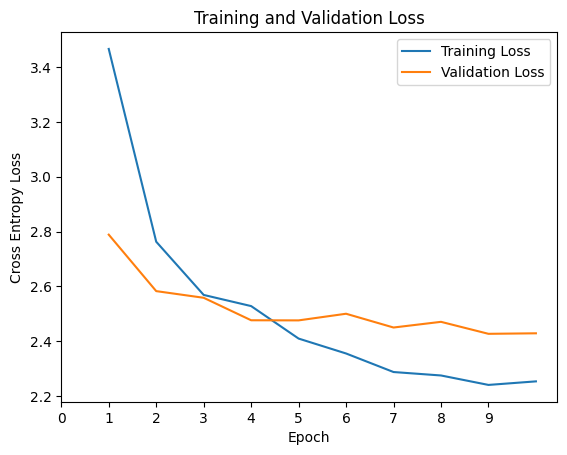

In [ ]:
#Training
drive_path = "/content/drive/My Drive/Colab Notebooks/CS5242 Project/Checkpoints"
checkpoint_filename = "model_checkpoint.pt"
# Initialize lists for losses
train_losses = []
val_losses = []
rouge_scores = []

# Initialize variables for early stopping
best_val_loss = float('inf')
epochs_no_improve = 0
num_epochs=10
patience = 3
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=True)


for param in model_summarizer.model.parameters():
    param.requires_grad = False

for name, param in model_summarizer.model.named_parameters():
  if 'lm_head' in name:  # Unfreeze parameters in the lm_head module
        param.requires_grad = True
  elif name.startswith('led.decoder.layers.11'):  # Unfreeze the last layer of the decoder
        param.requires_grad = True
  else:
        param.requires_grad = False




for epoch in range(num_epochs):

  #Train the model
  train_loss = model_summarizer.train_model(train_loader)
  avg_train_loss = train_loss / len(train_loader)
  train_losses.append(avg_train_loss)

  # Validate the model
  val_loss,total_rouge1_f1,total_rouge2_f1,total_rougeL_f1,num_samples  = model_summarizer.validate_model(val_loader)
  avg_rouge1_f1 = total_rouge1_f1 / num_samples
  avg_rouge2_f1 = total_rouge2_f1 / num_samples
  avg_rougeL_f1 = total_rougeL_f1 / num_samples
  rouge_scores.append((avg_rouge1_f1, avg_rouge2_f1, avg_rougeL_f1))

  avg_val_loss = val_loss / len(val_loader)
  val_losses.append(avg_val_loss)

 # model_summarizer.scheduler.step(val_loss)
  # Log metrics to file
  model_summarizer.log_metrics(epoch, avg_train_loss, avg_val_loss, (avg_rouge1_f1, avg_rouge2_f1, avg_rougeL_f1))

  print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

  #step the scheduler
  model_summarizer.scheduler.step()
  # Save checkpoint when the val loss improves
  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    epochs_no_improve = 0
    checkpoint_path = os.path.join(drive_path, checkpoint_filename)
    torch.save(model.state_dict(), checkpoint_path)
  else:
    epochs_no_improve += 1
    if epochs_no_improve == patience:
     print("Early stopping triggered")
     break



epochs = range(1, num_epochs +1)

# Plot and label the training and validation loss values
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.xticks(range(num_epochs))
plt.legend()
plt.title('Training and Validation Loss')
plt.show()




**Evaluate with Test Sets (20 pdf)**

In [ ]:


model_save_name = 'model_checkpoint.pt'
path = F"/content/drive/MyDrive/Colab Notebooks/Checkpoints/{model_save_name}"
#model.load_state_dict(torch.load(path, map_location=torch.device(DEVICE)))
model.load_state_dict(torch.load(path))
all_results = []
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
model.eval()
for data in test_loader:
    section_result = model_summarizer.test_model(data,model)
    all_results.append(section_result)

# Calculate average ROUGE scores across all sections
total_sections = len(all_results)
print("total sections",total_sections)
total_rouge1 = sum(result.get("ROUGE-1 F1", 0) for result in all_results)
total_rouge2 = sum(result.get("ROUGE-2 F1", 0) for result in all_results)
total_rougeL = sum(result.get("ROUGE-L F1", 0) for result in all_results)

average_rouge1 = total_rouge1 / total_sections
average_rouge2 = total_rouge2 / total_sections
average_rougeL = total_rougeL / total_sections

print("Average ROUGE-1 F1:", average_rouge1)
print("Average ROUGE-2 F1:", average_rouge2)
print("Average ROUGE-L F1:", average_rougeL)

# Save results to JSON file
with open("summary_results_with_rouge.json", "w") as json_file:
    json.dump(all_results, json_file, indent=4)


Section Name:  ['Abstract']
Generated Summary:  ['The mackey-higson bijection is a natural one-to-one correspondence between all
irreducible tempered representations of a group and its cartan motion group. The
text discusses the topology of the tempered dual e g and that of the unitary
dual c g. It also discusses the continuity of the mackey and Higginbotham
bijections. The section discusses the relation between the tempered and unitary
representations of the group and the Mackey-Higginbothaman bijection.']
Section Name:  ['1. Introduction']
Generated Summary:  ['The Mackey-higson bijection between the tempered dual of a group and the
unitary dual of the group is known to be a non-trivial one-to-one
correspondence. The bijection induces a homeomorphism between these duals, but
it is not continuous. The text discusses the properties of the bijection,
focusing on the topology of the component connected to each tempered dual. It
concludes with a discussion of the relationship between the 